**Network Construction - Netflix**

In [73]:
import pandas as pd
import re
import networkx as nx
import matplotlib.pyplot as plt


In [74]:
# Montiamo Google Drive per accedere ai file salvati
from google.colab import drive
drive.mount('/content/drive')

path_netflix="/content/drive/Shareddrives/information project/ANALISI X (Twitter)/Fase 2 - Scraping twitter/tweets_netflix.csv"
path_svb="/content/drive/Shareddrives/information project/ANALISI X (Twitter)/Fase 2 - Scraping twitter/tweets_svb.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 **Netflix**

In [75]:
#Caricamento dataset
df = pd.read_csv(path_netflix)
df.head()


,id,text,twitterUrl,retweetCount,replyCount,likeCount,quoteCount,isReply,date
0,1516532661803573258,#netflix 👀👀👀 this stock needs more than a pray...,https://twitter.com/live2beingu/status/1516532...,28,11,156,2,False,2022-04-19
1,1516544297147179009,◆初の会員減\nさきほどのNETFLIX決算。3月の有料会員数は2.21億人で、昨年末比で微...,https://twitter.com/goto_finance/status/151654...,382,6,2201,62,False,2022-04-19
2,1516511437354455041,Netflix lost 200K subscribers in Q1 and expect...,https://twitter.com/screentime/status/15165114...,3436,1436,37573,7594,False,2022-04-19
3,1516553092837396490,"Netflix CEO now says he’s open to a cheaper, a...",https://twitter.com/verge/status/1516553092837...,103,87,842,169,False,2022-04-19
4,1516511634298228738,Netflix had to spend a full page of its invest...,https://twitter.com/pkafka/status/151651163429...,60,8,188,16,False,2022-04-19


In [76]:
def extract_author(url):
    """
    Estrae l'username autore dal link Twitter
    """
    try:
        return url.split("twitter.com/")[1].split("/")[0]
    except:
        return None

df["author"] = df["twitterUrl"].apply(extract_author)
df = df.dropna(subset=["author"])


In [77]:
def extract_mentions(text):
    """
    Estrae tutte le menzioni @username dal testo
    """
    return re.findall(r'@(\w+)', text)

def extract_retweet(text):
    """
    Estrae l'utente retweettato se il tweet è un RT
    """
    match = re.match(r'RT @(\w+):', text)
    return match.group(1) if match else None


In [78]:
df["mentions"] = df["text"].apply(extract_mentions)
df["retweet_user"] = df["text"].apply(extract_retweet)



In [79]:
G_net = nx.DiGraph()

for _, row in df.iterrows():
    author = row["author"]

    # Aggiungiamo il nodo autore
    G_net.add_node(author)

    # Retweet: A → B
    if row["retweet_user"]:
        target = row["retweet_user"]
        if G_net.has_edge(author, target):
            G_net[author][target]["weight"] += 1
        else:
            G_net.add_edge(author, target, weight=1)

    # Mentions: A → B
    for target in row["mentions"]:
        if G_net.has_edge(author, target):
            G_net[author][target]["weight"] += 1
        else:
            G_net.add_edge(author, target, weight=1)


**Network Pre-processing (Netflix)**

In [80]:
# Rimuove nodi con grado totale minore o uguale a 1
low_degree_nodes = [n for n in G_net.nodes if G_net.degree(n) <= 1]
G_net.remove_nodes_from(low_degree_nodes)

print(f"Nodi a bassa interazione rimossi: {len(low_degree_nodes)}")


Nodi a bassa interazione rimossi: 813


In [81]:
# Rimuove nodi completamente isolati
isolated_nodes = list(nx.isolates(G_net))
G_net.remove_nodes_from(isolated_nodes)

print(f"Nodi isolati rimossi: {len(isolated_nodes)}")


Nodi isolati rimossi: 28


In [82]:
print(f"Nodi rimanenti: {G_net.number_of_nodes()}")
print(f"Archi rimanenti: {G_net.number_of_edges()}")


Nodi rimanenti: 56
Archi rimanenti: 52


**Centrality Analysis (Netflix)**

In [83]:
# In-degree centrality
in_degree_nflx = nx.in_degree_centrality(G_net)

# PageRank (pesato)
pagerank_nflx = nx.pagerank(G_net, weight="weight")

# Betweenness centrality
betweenness_nflx = nx.betweenness_centrality(G_net, normalized=True)

In [84]:
centrality_df = pd.DataFrame({
    "in_degree": in_degree_nflx,
    "pagerank": pagerank_nflx,
    "betweenness": betweenness_nflx
})

centrality_df = centrality_df.sort_values("pagerank", ascending=False)
centrality_df.head(10)



,in_degree,pagerank,betweenness
netflix,0.218182,0.103595,0.008754
Russo_Brothers,0.036364,0.100006,0.000000
dhanushkraja,0.018182,0.054054,0.000000
Netflix,0.109091,0.047115,0.000000
vanitakohlik,0.036364,0.026440,0.000000
QUT,0.036364,0.026440,0.000000
NetflixIndia,0.036364,0.022817,0.000000
WSJ,0.018182,0.022178,0.000000
BTS_twt,0.018182,0.018555,0.000000
gunfergunaydin,0.036364,0.018555,0.000000


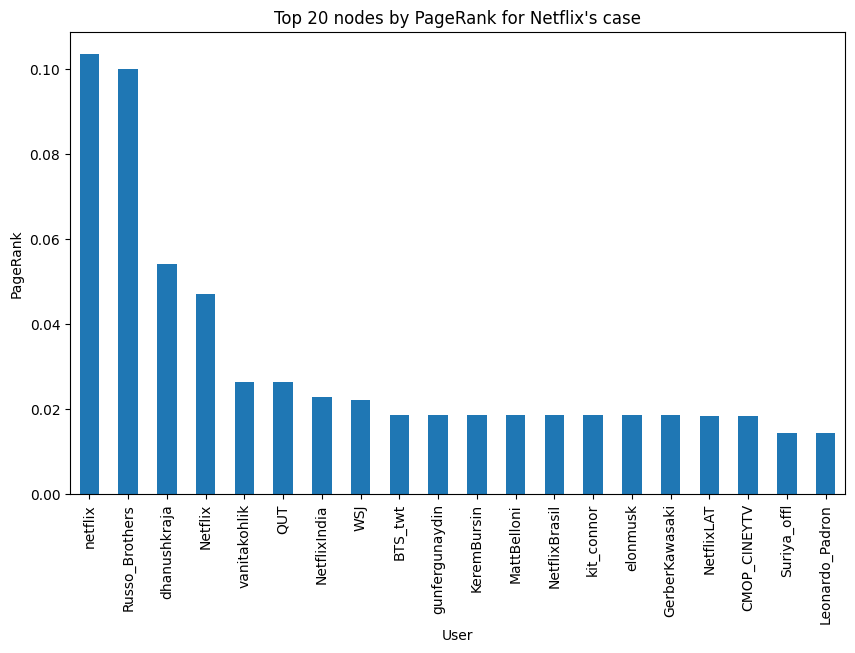

In [85]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
centrality_df["pagerank"].head(20).plot(kind="bar")
plt.title("Top 20 nodes by PageRank for Netflix's case")
plt.ylabel("PageRank")
plt.xlabel("User")
plt.show()


**Community detection (Netflix)**

In [86]:
!pip install python-igraph leidenalg


In [87]:
import igraph as ig
import leidenalg
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [88]:
# Preparazione nodi
nodes = list(G_net.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

# Preparazione archi
edges = []
weights = []

for u, v, d in G_net.edges(data=True):
    edges.append((node_index[u], node_index[v]))
    weights.append(d["weight"])

# Costruzione grafo iGraph
g_ig = ig.Graph(
    n=len(nodes),
    edges=edges,
    directed=True
)

g_ig.es["weight"] = weights
g_ig.vs["name"] = nodes


In [89]:
partition = leidenalg.find_partition(
    g_ig,
    leidenalg.RBConfigurationVertexPartition,
    weights="weight",
    resolution_parameter=1.0
)


In [90]:
# Assegniamo community a ogni nodo
community_map = {
    g_ig.vs[i]["name"]: partition.membership[i]
    for i in range(len(g_ig.vs))
}

nx.set_node_attributes(G_net, community_map, "community")


In [91]:
num_communities = len(set(partition.membership))
print(f"Numero di community individuate: {num_communities}")


Numero di community individuate: 14


In [92]:
community_df = (
    pd.DataFrame.from_dict(community_map, orient="index", columns=["community"])
    .reset_index()
    .rename(columns={"index": "user"})
)

community_sizes = community_df["community"].value_counts().reset_index()
community_sizes.columns = ["community", "size"]
community_sizes


,community,size
0,0,13
1,1,9
2,2,5
3,3,4
4,4,4
5,5,3
6,6,3
7,7,3
8,9,2
9,8,2


/tmp/ipython-input-2519955695.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_communities))


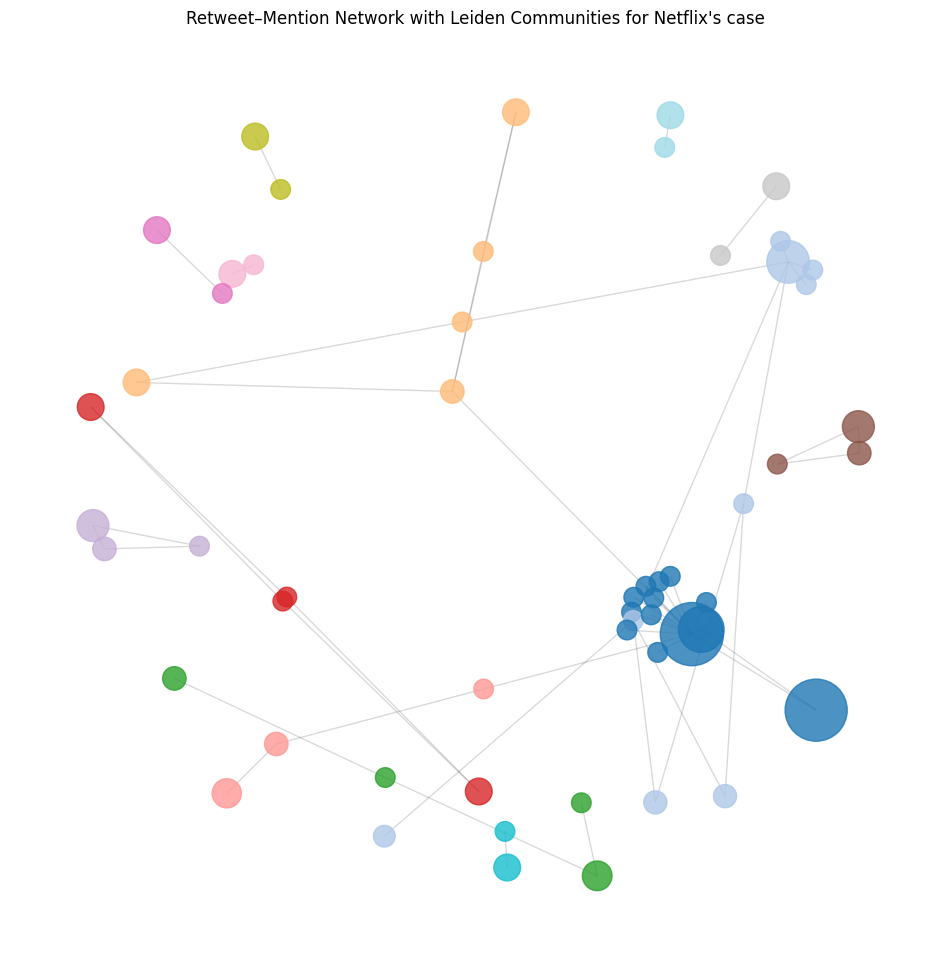

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_net, k=0.15, seed=42)

node_colors = [G_net.nodes[n]["community"] for n in G_net.nodes]
node_sizes = [pagerank_nflx[n] * 20000 for n in G_net.nodes]

nx.draw_networkx_nodes(
    G_net,
    pos,
    node_color=node_colors,
    cmap="tab20",
    node_size=node_sizes,
    alpha=0.8
)

# Get the list of unique community IDs from G_net
# Assuming G_net nodes have 'community' attribute set from cell 2cnCJ4hZlUOv
unique_communities = sorted(list(set(nx.get_node_attributes(G_net, 'community').values())))

# Get the 'tab20' colormap
cmap = plt.cm.get_cmap('tab20', len(unique_communities))

# Create manual patches for the legend
patches = [mpatches.Patch(color=cmap(c_id), label=f"Community {c_id}") for c_id in unique_communities]

nx.draw_networkx_edges(G_net, pos, alpha=0.15, arrows=False)

plt.title("Retweet–Mention Network with Leiden Communities for Netflix's case")
plt.axis("off")
plt.show()

/tmp/ipython-input-3354434501.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_communities))


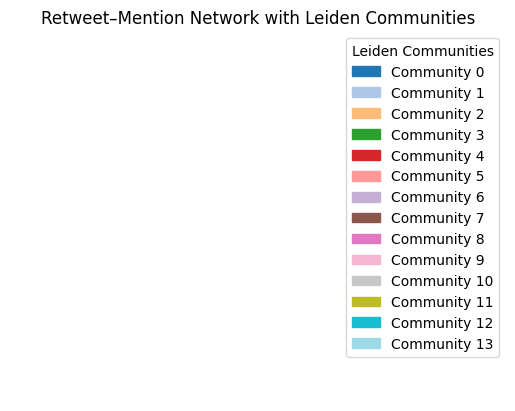

In [94]:
import matplotlib.patches as mpatches

# Get the list of unique community IDs from G_net
unique_communities = sorted(list(set(nx.get_node_attributes(G_net, 'community').values())))

# Get the 'tab20' colormap
cmap = plt.cm.get_cmap('tab20', len(unique_communities))

# Creazione manuale delle patch per la leggenda
patches = [mpatches.Patch(color=cmap(c_id), label=f"Community {c_id}") for c_id in unique_communities]

plt.legend(handles=patches, loc='best', fontsize=10, title="Leiden Communities")
plt.title("Retweet–Mention Network with Leiden Communities")
plt.axis("off")
plt.show()

**Struttura delle community ed echo-like behavior (Netflix)**

In [95]:
intra_edges = 0
inter_edges = 0

for u, v in G_net.edges():
    if G_net.nodes[u]["community"] == G_net.nodes[v]["community"]:
        intra_edges += 1
    else:
        inter_edges += 1

total_edges = intra_edges + inter_edges

print(f"Intra-community edges: {intra_edges}")
print(f"Inter-community edges: {inter_edges}")
print(f"Share intra-community: {intra_edges / total_edges:.2f}")


Intra-community edges: 49
Inter-community edges: 3
Share intra-community: 0.94


In [96]:
from collections import defaultdict

community_edges = defaultdict(lambda: {"intra": 0, "inter": 0})

for u, v in G_net.edges():
    cu = G_net.nodes[u]["community"]
    cv = G_net.nodes[v]["community"]

    if cu == cv:
        community_edges[cu]["intra"] += 1
    else:
        community_edges[cu]["inter"] += 1

community_structure = pd.DataFrame.from_dict(
    community_edges, orient="index"
).reset_index().rename(columns={"index": "community"})

community_structure["intra_share"] = (
    community_structure["intra"] /
    (community_structure["intra"] + community_structure["inter"])
)

community_structure.sort_values("intra_share", ascending=False)


,community,intra,inter,intra_share
0,1,10,0,1.000000
1,0,13,0,1.000000
3,3,3,0,1.000000
4,10,1,0,1.000000
7,9,1,0,1.000000
6,11,1,0,1.000000
10,12,1,0,1.000000
11,7,3,0,1.000000
8,13,1,0,1.000000
9,6,3,0,1.000000


**SVB**

In [97]:
# Carica il dataset (SVB o Netflix)
df = pd.read_csv(path_svb)  # cambia nome file se serve
df.head()


,id,text,twitterUrl,retweetCount,replyCount,likeCount,quoteCount,isReply,date
0,1634329302845079555,There is more than $22 Trillion in the U.S. ba...,https://twitter.com/gaborgurbacs/status/163432...,1780,307,4956,336,False,2023-03-10
1,1634029130923794435,Silicon Valley Bank in the US is struggling fo...,https://twitter.com/AdityaD_Shah/status/163402...,478,367,2323,68,False,2023-03-10
2,1634306547638566916,"Earlier today, America's 16th largest bank, Si...",https://twitter.com/itsDanny_V/status/16343065...,487,57,1657,57,False,2023-03-10
3,1634227592227336195,🏦📉 SVB Crash Explained📉🏦\n\nSilicon Valley Ban...,https://twitter.com/FabiusMercurius/status/163...,2744,178,8627,271,False,2023-03-10
4,1634306931870375936,Silicon Valley Bank experienced $42 BILLION in...,https://twitter.com/JosephPolitano/status/1634...,264,36,1355,102,False,2023-03-10


In [98]:
def extract_author(url):
    """
    Estrae l'username autore dal link Twitter
    """
    try:
        return url.split("twitter.com/")[1].split("/")[0]
    except:
        return None

df["author"] = df["twitterUrl"].apply(extract_author)
df = df.dropna(subset=["author"])


In [99]:
def extract_mentions(text):
    """
    Estrae tutte le menzioni @username dal testo
    """
    return re.findall(r'@(\w+)', text)

def extract_retweet(text):
    """
    Estrae l'utente retweettato se il tweet è un RT
    """
    match = re.match(r'RT @(\w+):', text)
    return match.group(1) if match else None


In [100]:
df["mentions"] = df["text"].apply(extract_mentions)
df["retweet_user"] = df["text"].apply(extract_retweet)


In [101]:
G_svb = nx.DiGraph()

for _, row in df.iterrows():
    author = row["author"]

    # Aggiungiamo il nodo autore
    G_svb.add_node(author)

    # Retweet: A → B
    if row["retweet_user"]:
        target = row["retweet_user"]
        if G_svb.has_edge(author, target):
           G_svb[author][target]["weight"] += 1
        else:
            G_svb.add_edge(author, target, weight=1)

    # Mentions: A → B
    for target in row["mentions"]:
        if G_svb.has_edge(author, target):
            G_svb[author][target]["weight"] += 1
        else:
           G_svb.add_edge(author, target, weight=1)


**Network Pre-processiong (SVB)**

In [102]:
# Rimuove nodi con grado totale minore o uguale a 1
low_degree_nodes = [n for n in G_svb.nodes if G_svb.degree(n) <= 1]
G_svb.remove_nodes_from(low_degree_nodes)

print(f"Nodi a bassa interazione rimossi: {len(low_degree_nodes)}")


Nodi a bassa interazione rimossi: 489


In [103]:
# Rimuove nodi completamente isolati
isolated_nodes = list(nx.isolates(G_svb))
G_svb.remove_nodes_from(isolated_nodes)

print(f"Nodi isolati rimossi: {len(isolated_nodes)}")


Nodi isolati rimossi: 13


In [104]:
print(f"Nodi rimanenti: {G_svb.number_of_nodes()}")
print(f"Archi rimanenti: {G_svb.number_of_edges()}")


Nodi rimanenti: 29
Archi rimanenti: 20


**Centrality Analysis(svb)**

In [105]:
# In-degree centrality
in_degree_svb = nx.in_degree_centrality(G_svb)

# PageRank (pesato)
pagerank_svb = nx.pagerank(G_svb, weight="weight")

# Betweenness centrality
betweenness_svb = nx.betweenness_centrality(G_svb, normalized=True)

In [106]:
centrality_df = pd.DataFrame({
    "in_degree": in_degree_svb,
    "pagerank": pagerank_svb,
    "betweenness": betweenness_svb
})

centrality_df = centrality_df.sort_values("pagerank", ascending=False)
centrality_df.head(10)


,in_degree,pagerank,betweenness
PowerLunch,0.035714,0.106287,0.0
lanceyu_,0.035714,0.106287,0.0
rapplerdotcom,0.035714,0.106287,0.0
BBNTimes_en,0.035714,0.106287,0.0
SecYellen,0.071429,0.043054,0.0
MarkWarner,0.071429,0.043054,0.0
elonmusk,0.071429,0.034922,0.0
JoeBiden,0.071429,0.034922,0.0
VivekGRamaswamy,0.035714,0.029500,0.0
_hadleygamble,0.035714,0.029500,0.0


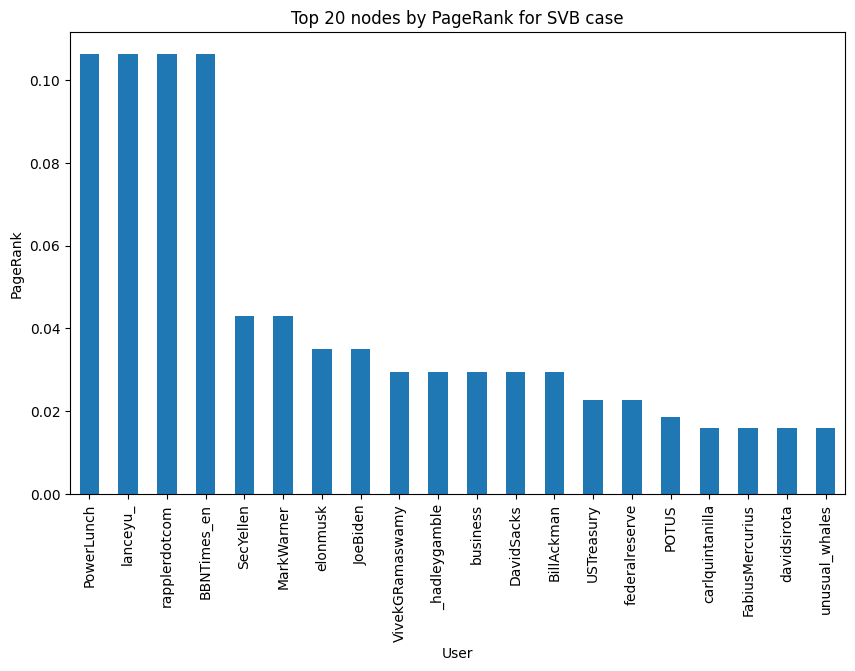

In [107]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
centrality_df["pagerank"].head(20).plot(kind="bar")
plt.title("Top 20 nodes by PageRank for SVB case")
plt.ylabel("PageRank")
plt.xlabel("User")
plt.show()

In [108]:
import igraph as ig
import leidenalg
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt


In [109]:
# Preparazione nodi
nodes = list(G_svb.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

# Preparazione archi
edges = []
weights = []

for u, v, d in G_svb.edges(data=True):
    edges.append((node_index[u], node_index[v]))
    weights.append(d["weight"])

# Costruzione grafo iGraph
g_ig = ig.Graph(
    n=len(nodes),
    edges=edges,
    directed=True
)

g_ig.es["weight"] = weights
g_ig.vs["name"] = nodes

In [110]:
partition = leidenalg.find_partition(
    g_ig,
    leidenalg.RBConfigurationVertexPartition,
    weights="weight",
    resolution_parameter=1.0
)

In [111]:
# Assegniamo community a ogni nodo
community_map = {
    g_ig.vs[i]["name"]: partition.membership[i]
    for i in range(len(g_ig.vs))
}

nx.set_node_attributes(G_svb, community_map, "community")

In [112]:
num_communities = len(set(partition.membership))
print(f"Numero di community individuate: {num_communities}")


Numero di community individuate: 12


In [113]:
community_df = (
    pd.DataFrame.from_dict(community_map, orient="index", columns=["community"])
    .reset_index()
    .rename(columns={"index": "user"})
)

community_sizes = community_df["community"].value_counts().reset_index()
community_sizes.columns = ["community", "size"]
community_sizes


,community,size
0,0,6
1,1,3
2,3,3
3,2,3
4,4,2
5,5,2
6,6,2
7,7,2
8,9,2
9,8,2


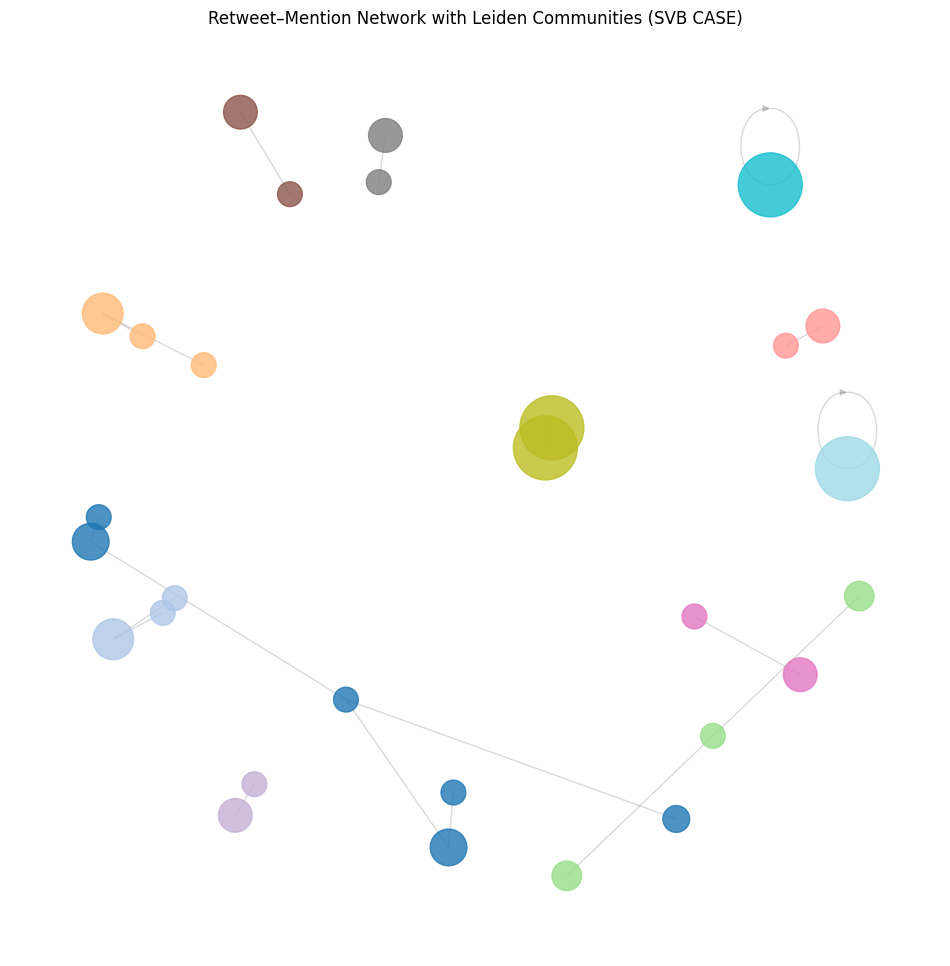

In [114]:
import matplotlib.pyplot as plt

nx.set_node_attributes(G_svb, community_map, "community")

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_svb, k=0.15, seed=42)

node_colors = [G_svb.nodes[n]["community"] for n in G_svb.nodes]
node_sizes = [pagerank_svb[n] * 20000 for n in G_svb.nodes]

nx.draw_networkx_nodes(
    G_svb,
    pos,
    node_color=node_colors,
    cmap="tab20",
    node_size=node_sizes,
    alpha=0.8
)

nx.draw_networkx_edges(G_svb, pos, alpha=0.15, arrows=False)

plt.title("Retweet–Mention Network with Leiden Communities (SVB CASE)")
plt.axis("off")
plt.show()

/tmp/ipython-input-3354434501.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', len(unique_communities))


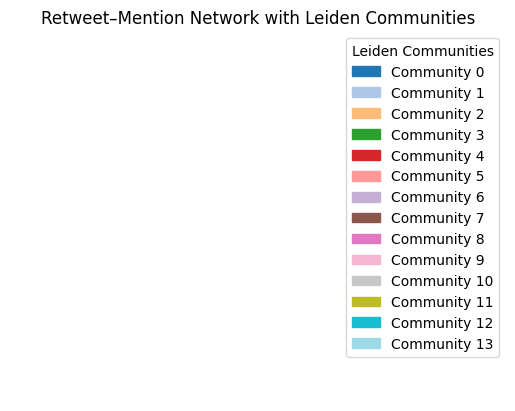

In [115]:
import matplotlib.patches as mpatches

# Get the list of unique community IDs from G_net
unique_communities = sorted(list(set(nx.get_node_attributes(G_net, 'community').values())))

# Get the 'tab20' colormap
cmap = plt.cm.get_cmap('tab20', len(unique_communities))

# Creazione manuale delle patch per la leggenda
patches = [mpatches.Patch(color=cmap(c_id), label=f"Community {c_id}") for c_id in unique_communities]

plt.legend(handles=patches, loc='best', fontsize=10, title="Leiden Communities")
plt.title("Retweet–Mention Network with Leiden Communities")
plt.axis("off")
plt.show()

**Struttura delle community ed echo-like behavior (svb)**

In [116]:
intra_edges = 0
inter_edges = 0

for u, v in G_svb.edges():
    if G_svb.nodes[u]["community"] == G_svb.nodes[v]["community"]:
        intra_edges += 1
    else:
        inter_edges += 1

total_edges = intra_edges + inter_edges

print(f"Intra-community edges: {intra_edges}")
print(f"Inter-community edges: {inter_edges}")
print(f"Share intra-community: {intra_edges / total_edges:.2f}")


Intra-community edges: 20
Inter-community edges: 0
Share intra-community: 1.00


In [117]:
from collections import defaultdict

community_edges = defaultdict(lambda: {"intra": 0, "inter": 0})

for u, v in G_svb.edges():
    cu = G_svb.nodes[u]["community"]
    cv = G_svb.nodes[v]["community"]

    if cu == cv:
        community_edges[cu]["intra"] += 1
    else:
        community_edges[cu]["inter"] += 1

community_structure = pd.DataFrame.from_dict(
    community_edges, orient="index"
).reset_index().rename(columns={"index": "community"})

community_structure["intra_share"] = (
    community_structure["intra"] /
    (community_structure["intra"] + community_structure["inter"])
)

community_structure.sort_values("intra_share", ascending=False)


,community,intra,inter,intra_share
0,4,1,0,1.0
1,1,2,0,1.0
2,0,5,0,1.0
3,5,1,0,1.0
4,2,2,0,1.0
5,7,1,0,1.0
6,10,1,0,1.0
7,3,2,0,1.0
8,11,1,0,1.0
9,8,1,0,1.0


**Confronto strutturale**

In [118]:
def network_summary(G, pagerank):
    return {
        "nodes": G.number_of_nodes(),
        "edges": G.number_of_edges(),
        "communities": len(set(nx.get_node_attributes(G, "community").values())),
        "avg_pagerank": sum(pagerank.values()) / len(pagerank)
    }

summary_svb = network_summary(G_svb, pagerank_svb)
summary_nflx = network_summary(G_net, pagerank_nflx)

pd.DataFrame([summary_svb, summary_nflx], index=["SVB", "Netflix"])


,nodes,edges,communities,avg_pagerank
SVB,29,20,12,0.034483
Netflix,56,52,14,0.017857


/tmp/ipython-input-3113795630.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nflx = plt.cm.get_cmap('tab20', len(unique_communities_nflx))
/tmp/ipython-input-3113795630.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_svb = plt.cm.get_cmap('tab20', len(unique_communities_svb))


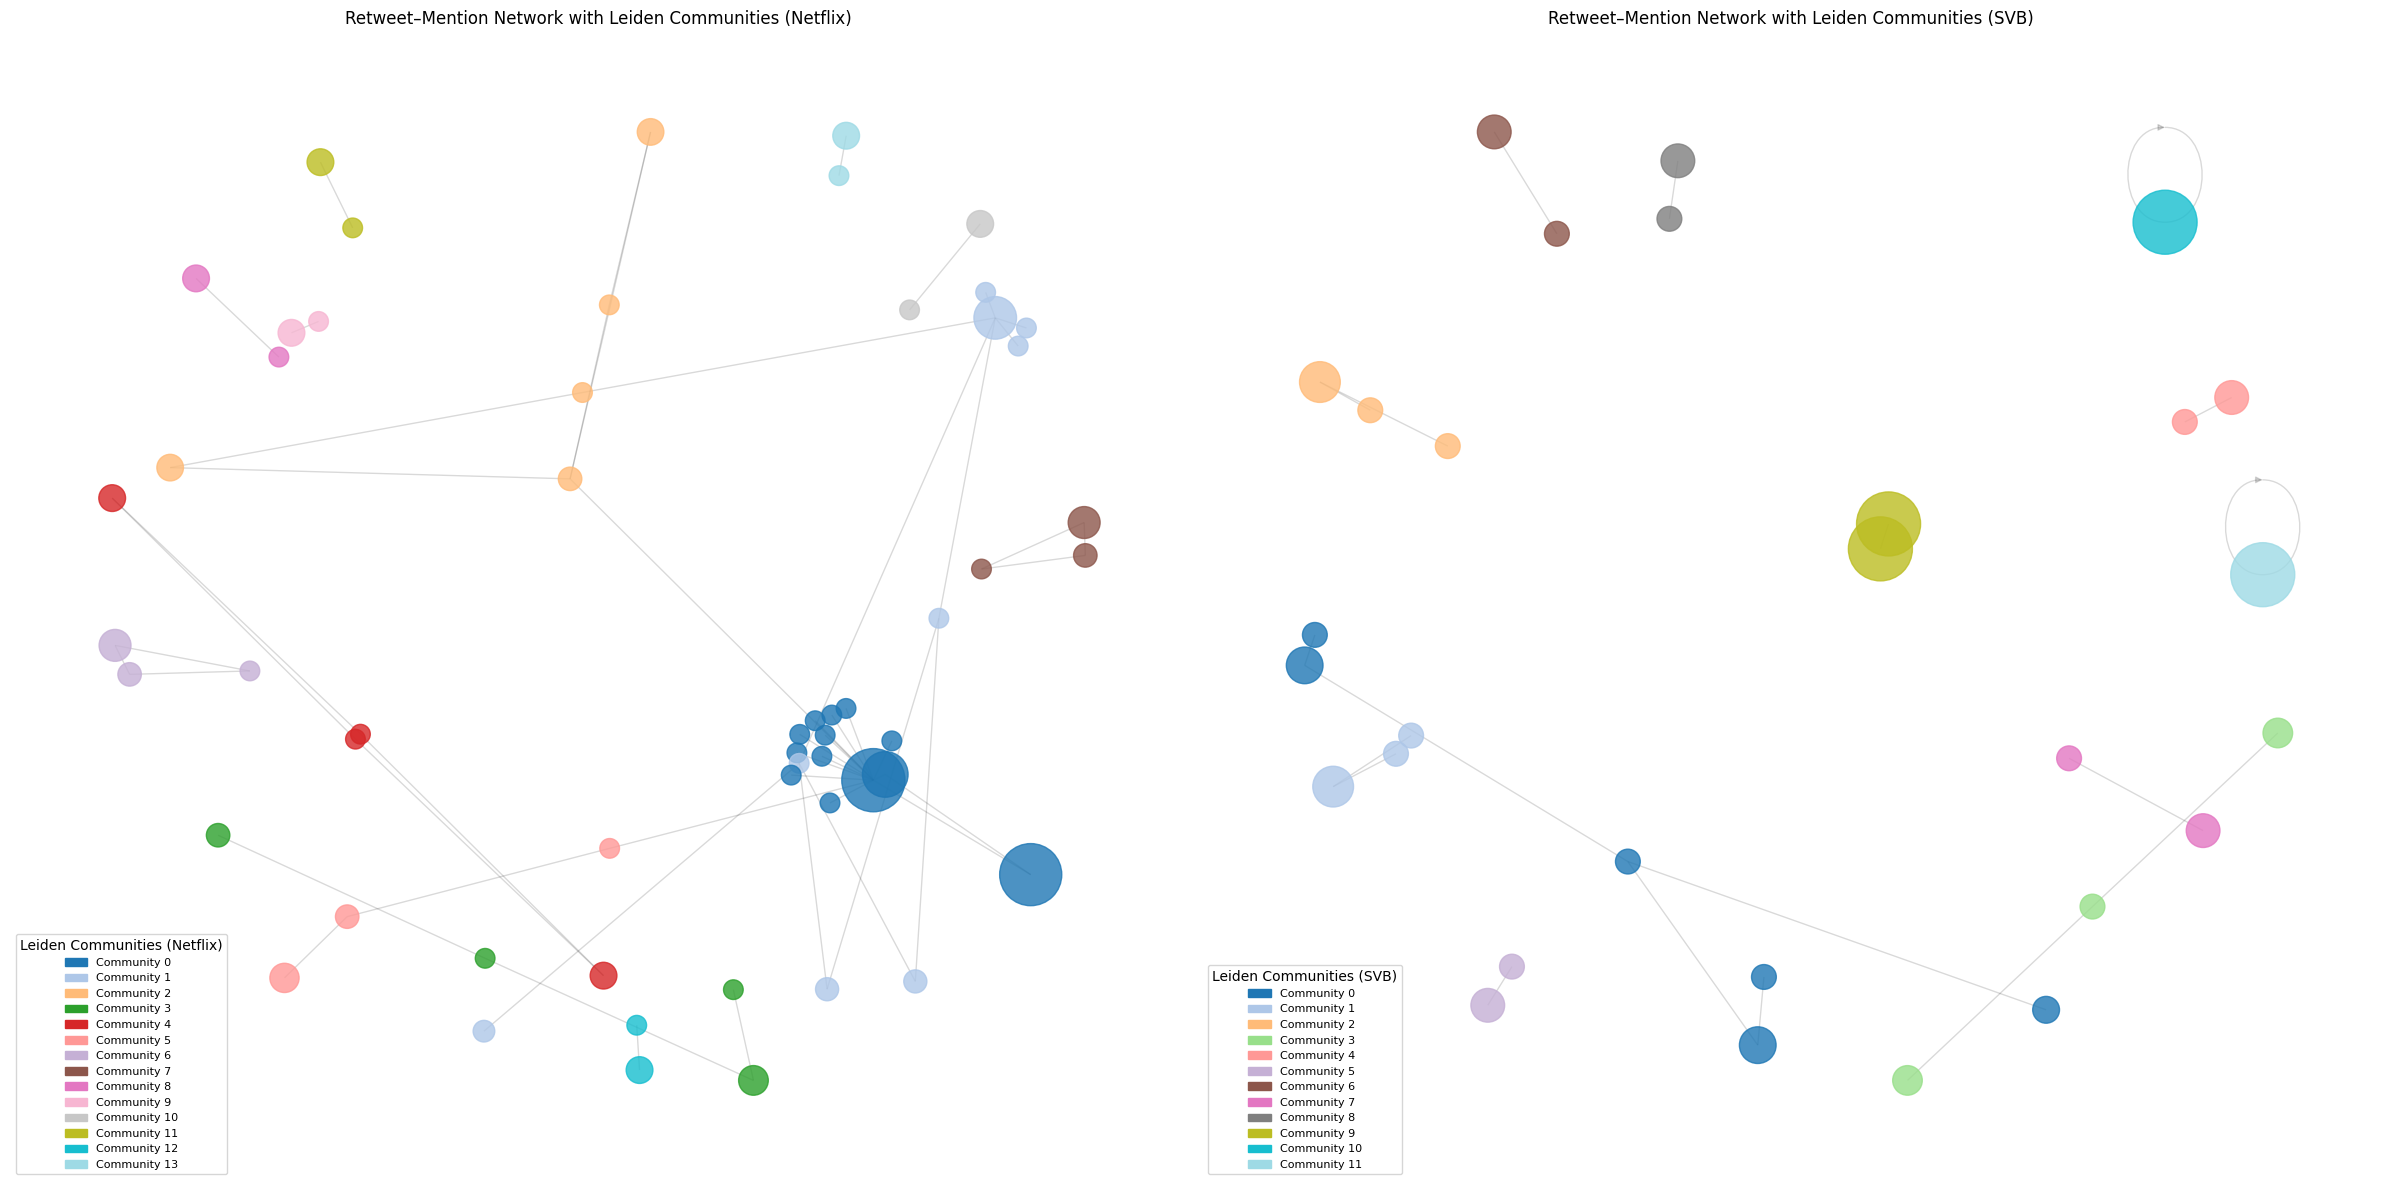

In [119]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import networkx as nx

plt.figure(figsize=(24, 12))

# --- Netflix Network Graph (Left Subplot) ---
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot

pos_nflx = nx.spring_layout(G_net, k=0.15, seed=42)

node_colors_nflx = [G_net.nodes[n]["community"] for n in G_net.nodes]
node_sizes_nflx = [pagerank_nflx[n] * 20000 for n in G_net.nodes]

nx.draw_networkx_nodes(
    G_net,
    pos_nflx,
    node_color=node_colors_nflx,
    cmap="tab20",
    node_size=node_sizes_nflx,
    alpha=0.8
)
nx.draw_networkx_edges(G_net, pos_nflx, alpha=0.15, arrows=False)

# Get the list of unique community IDs from G_net
unique_communities_nflx = sorted(list(set(nx.get_node_attributes(G_net, 'community').values())))

# Get the 'tab20' colormap
cmap_nflx = plt.cm.get_cmap('tab20', len(unique_communities_nflx))

# Create manual patches for the legend
patches_nflx = [mpatches.Patch(color=cmap_nflx(c_id), label=f"Community {c_id}") for c_id in unique_communities_nflx]
plt.legend(handles=patches_nflx, loc='lower left', fontsize=8, title="Leiden Communities (Netflix)")

plt.title("Retweet–Mention Network with Leiden Communities (Netflix)")
plt.axis("off")

# --- SVB Network Graph (Right Subplot) ---
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot

pos_svb = nx.spring_layout(G_svb, k=0.15, seed=42)

node_colors_svb = [G_svb.nodes[n]["community"] for n in G_svb.nodes]
# Assuming pagerank_svb was calculated previously for G_svb
node_sizes_svb = [pagerank_svb[n] * 20000 for n in G_svb.nodes]

nx.draw_networkx_nodes(
    G_svb,
    pos_svb,
    node_color=node_colors_svb,
    cmap="tab20",
    node_size=node_sizes_svb,
    alpha=0.8
)
nx.draw_networkx_edges(G_svb, pos_svb, alpha=0.15, arrows=False)

# Get the list of unique community IDs from G_svb
unique_communities_svb = sorted(list(set(nx.get_node_attributes(G_svb, 'community').values())))

# Get the 'tab20' colormap
cmap_svb = plt.cm.get_cmap('tab20', len(unique_communities_svb))

# Create manual patches for the legend
patches_svb = [mpatches.Patch(color=cmap_svb(c_id), label=f"Community {c_id}") for c_id in unique_communities_svb]
plt.legend(handles=patches_svb, loc='lower left', fontsize=8, title="Leiden Communities (SVB)")

plt.title("Retweet–Mention Network with Leiden Communities (SVB)")
plt.axis("off")

plt.tight_layout()
plt.show()

In [122]:
import networkx as nx
import numpy as np
from collections import Counter

def network_statistics(G, partition):
    # Basic size
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()

    # Density
    density = nx.density(G)

    # Degree
    degrees = np.array([d for _, d in G.degree()])
    avg_degree = degrees.mean()

    # Centralization (Freeman)
    max_degree = degrees.max()
    degree_centralization = np.sum(max_degree - degrees) / ((n_nodes - 1) * (n_nodes - 2))

    # Betweenness centralization
    betweenness = np.array(list(nx.betweenness_centrality(G, normalized=True).values()))
    max_bet = betweenness.max()
    betweenness_centralization = np.sum(max_bet - betweenness) / (n_nodes - 1)

    # Modularity
    communities = {}
    for node, comm in partition.items():
        communities.setdefault(comm, set()).add(node)
    modularity = nx.algorithms.community.quality.modularity(G, communities.values())

    # Intra / inter community edges
    intra_edges = 0
    for u, v in G.edges():
        if partition[u] == partition[v]:
            intra_edges += 1
    intra_share = intra_edges / n_edges if n_edges > 0 else 0

    return {
        "nodes": n_nodes,
        "edges": n_edges,
        "density": density,
        "avg_degree": avg_degree,
        "degree_centralization": degree_centralization,
        "betweenness_centralization": betweenness_centralization,
        "modularity": modularity,
        "intra_community_share": intra_share
    }


# === CALCOLO STATISTICHE ===
# Retrieve community information directly from the graph node attributes
partition_net_data = nx.get_node_attributes(G_net, 'community')
partition_svb_data = nx.get_node_attributes(G_svb, 'community')

stats_netflix = network_statistics(G=G_net, partition=partition_net_data)
stats_svb = network_statistics(G=G_svb, partition=partition_svb_data)

# === STAMPA RISULTATI ===
print("=== NETWORK STATISTICS ===\n")

for metric in stats_netflix.keys():
    print(f"{metric}")
    print(f"  Netflix: {stats_netflix[metric]:.4f}")
    print(f"  SVB:     {stats_svb[metric]:.4f}")
    print()


=== NETWORK STATISTICS ===

nodes
  Netflix: 56.0000
  SVB:     29.0000

edges
  Netflix: 52.0000
  SVB:     20.0000

density
  Netflix: 0.0169
  SVB:     0.0246

avg_degree
  Netflix: 1.8571
  SVB:     1.3793

degree_centralization
  Netflix: 0.2290
  SVB:     0.0622

betweenness_centralization
  Netflix: 0.0087
  SVB:     0.0000

modularity
  Netflix: 0.7932
  SVB:     0.8512

intra_community_share
  Netflix: 0.9423
  SVB:     1.0000

